# 3D Convolutions for track finding

In this notebook we try 3D convolution instead of LSTM for classifying pixels, etc.

The detector is, as before, composed of square 2D layers.
I generate straight tracks that pass through every layer and leave hits deterministically.

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import keras.backend as K
from keras.regularizers import l2

# Local imports
from metrics import calc_hit_accuracy
from toydata import generate_data, track_hit_coords
from drawing import draw_layers, draw_projections, draw_train_history

# Magic
%matplotlib notebook

Using Theano backend.
Using gpu device 7: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# Set random seed
np.random.seed(2017)

## Data generation

In [3]:
# Configuration
num_det_layers = 10
det_layer_size = 32
num_seed_layers = 3
avg_bkg_tracks = 0
noise_prob = 0.
det_shape = (num_det_layers, det_layer_size, det_layer_size)

In [4]:
def batch_generator(num_batch, det_shape=det_shape,
                    num_seed_layers=num_seed_layers,
                    avg_bkg_tracks=avg_bkg_tracks,
                    noise_prob=noise_prob):
    """Generator of toy data batches for training"""
    shape = (num_batch,) + det_shape
    while True:
        events, sig_tracks, _ = generate_data(
            shape, num_seed_layers=num_seed_layers,
            avg_bkg_tracks=avg_bkg_tracks,
            noise_prob=noise_prob, verbose=False)
        train_target = sig_tracks.reshape(num_batch, det_shape[0], -1)
        yield (events, train_target)

## Define the model

In [5]:
def build_conv_model(shape, num_conv_layers=10, num_filter=8, filter_size=(3,3,3)):
    """Build the convolutional autoencoder model"""
    inputs = layers.Input(shape=shape)

    # Need a 'channel' dimension for 3D convolution, though we have only 1 channel
    hidden = layers.Reshape((1,)+shape)(inputs)

    # 3D convolutional layers
    for _ in range(num_conv_layers):
        hidden = layers.Conv3D(num_filter, *filter_size,
                               border_mode='same', activation='relu')(hidden)

    # Final convolution without activation
    hidden = layers.Conv3D(1, *filter_size, border_mode='same')(hidden)
    # Reshape to flatten each detector layer
    hidden = layers.Reshape((shape[0], shape[1]*shape[2]))(hidden)
    # Final softmax activation
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)

    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

## Training

In [6]:
model = build_conv_model(det_shape, num_filter=64, num_conv_layers=5)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10, 32, 32)    0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 1, 10, 32, 32) 0           input_1[0][0]                    
____________________________________________________________________________________________________
convolution3d_1 (Convolution3D)  (None, 64, 10, 32, 32)1792        reshape_1[0][0]                  
____________________________________________________________________________________________________
convolution3d_2 (Convolution3D)  (None, 64, 10, 32, 32)110656      convolution3d_1[0][0]            
___________________________________________________________________________________________

In [7]:
batch_size = 32
num_event = 128000
events_per_epoch = 16000
num_epoch = num_event / events_per_epoch

In [8]:
history = model.fit_generator(batch_generator(batch_size),
                              samples_per_epoch=events_per_epoch,
                              nb_epoch=num_epoch)

Epoch 1/8
16000/16000 [==============================] - 380s - loss: 0.0974 - acc: 0.9832   
Epoch 2/8
16000/16000 [==============================] - 357s - loss: 2.3983e-05 - acc: 1.0000   
Epoch 3/8
16000/16000 [==============================] - 363s - loss: 6.3752e-06 - acc: 1.0000   
Epoch 4/8
16000/16000 [==============================] - 356s - loss: 3.6736e-06 - acc: 1.0000   
Epoch 5/8
16000/16000 [==============================] - 358s - loss: 1.3570e-06 - acc: 1.0000   
Epoch 6/8
16000/16000 [==============================] - 362s - loss: 6.9937e-07 - acc: 1.0000   
Epoch 7/8
16000/16000 [==============================] - 352s - loss: 5.3762e-07 - acc: 1.0000   
Epoch 8/8
16000/16000 [==============================] - 360s - loss: 4.4442e-07 - acc: 1.0000   


<IPython.core.display.Javascript object>


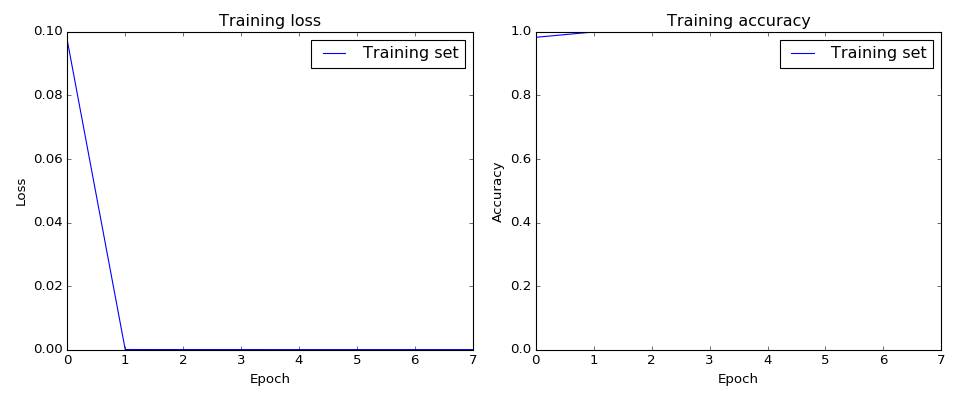

In [11]:
draw_train_history(history, draw_val=False);

## Evaluate results

In [12]:
# Generate a new test dataset
test_num_event = 51200
test_events, test_sigtrks, test_sigparams = generate_data(
    (test_num_event,) + det_shape, num_seed_layers=num_seed_layers,
    avg_bkg_tracks=avg_bkg_tracks, noise_prob=noise_prob)
test_target = test_sigtrks.reshape(test_num_event, num_det_layers, -1)

Sizes of arrays
  events:     2097.15 MB
  sig_tracks: 2097.15 MB
  bkg_tracks: 2097.15 MB
  noise:      524.288 MB
  sig_params: 1.6384 MB


In [13]:
# Run the model on the test set
test_preds = model.predict(test_events, batch_size=batch_size, verbose=1)

51200/51200 [==============================] - 385s   


In [14]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test_preds, test_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
test_scores = test_preds * test_events.reshape(test_num_event, num_det_layers, -1)
hit_accuracy = calc_hit_accuracy(test_scores, test_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 1.0
Accuracy of classified hit:  1.0


Input data example event:


<IPython.core.display.Javascript object>


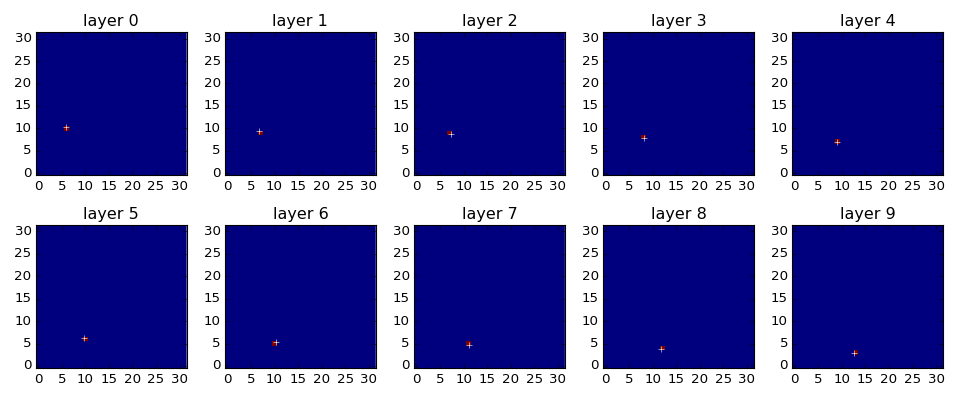

Model prediction:


<IPython.core.display.Javascript object>


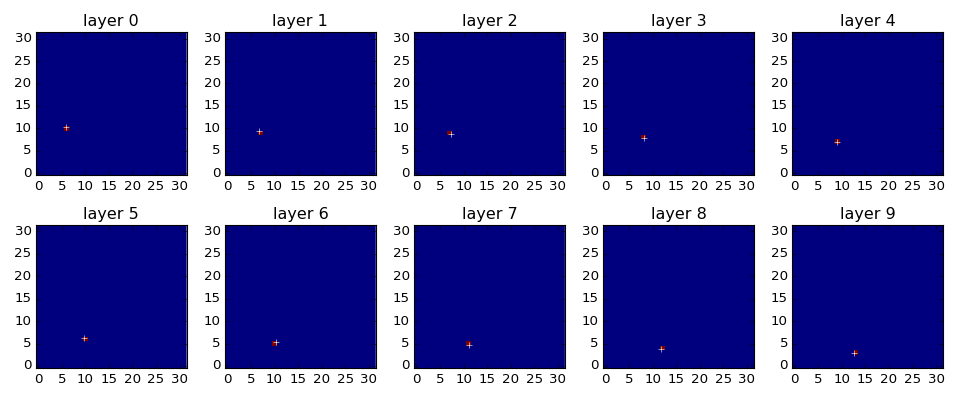

Projected input data:


<IPython.core.display.Javascript object>


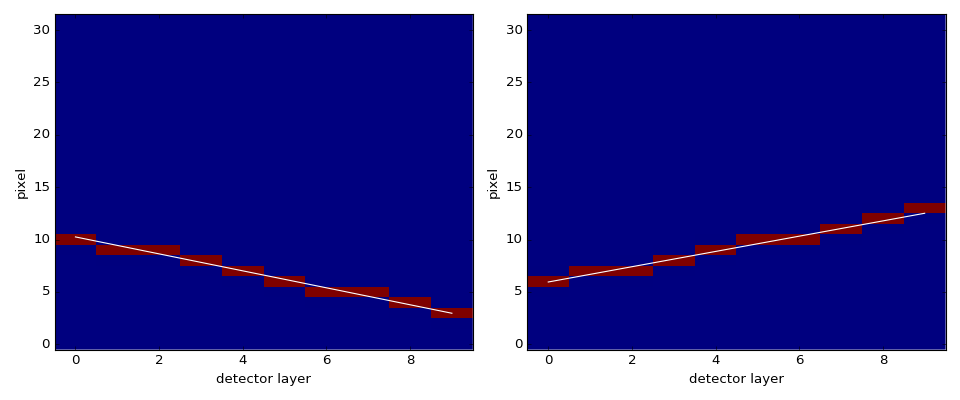

Projected model prediction:


<IPython.core.display.Javascript object>


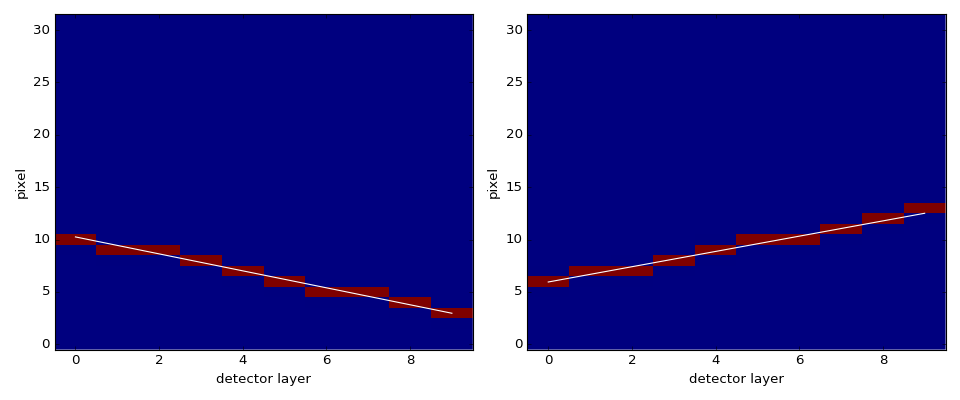

<IPython.core.display.Javascript object>


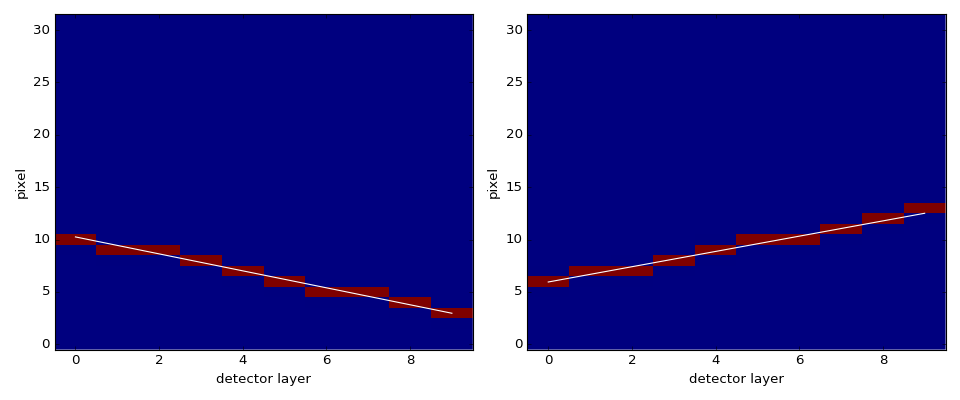

In [18]:
# Select an event to visualize
disp_idx = 1

# Get the hit coordinates for drawing
idx = np.arange(num_det_layers)
xtruth, ytruth = track_hit_coords(test_sigparams[disp_idx],
                                  idx, as_type=np.float32)

# Draw the layers
print('Input data example event:')
draw_layers(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Model prediction:')
draw_layers(test_preds[disp_idx].reshape(det_shape),
            truthx=xtruth, truthy=ytruth)
print('Projected input data:')
draw_projections(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Projected model prediction:')
draw_projections(test_preds[disp_idx].reshape(det_shape),
                 truthx=xtruth, truthy=ytruth)

## Visualize the first layer convolutional filters

In [19]:
def draw_filters(filters, figsize=(6,48)):
    filters = np.squeeze(filters)
    # normalize the weights
    norm = np.abs(filters).max()*2
    filters = filters / norm + 0.5
    #print(filters.shape)
    nfilters, nslices = filters.shape[0:2]
    print('drawing %d filters in %d slices' % (nfilters, nslices))
    plt.figure(figsize=figsize)
    for ifilt in range(nfilters):
        for islice in range(nslices):
            plt.subplot(nfilters, nslices, ifilt*nslices + islice + 1)
            plt.imshow(filters[ifilt, islice], vmin=0, vmax=1,
                       interpolation='none', cmap='coolwarm')
            plt.axis('off')
    plt.tight_layout()

drawing 64 filters in 3 slices


<IPython.core.display.Javascript object>


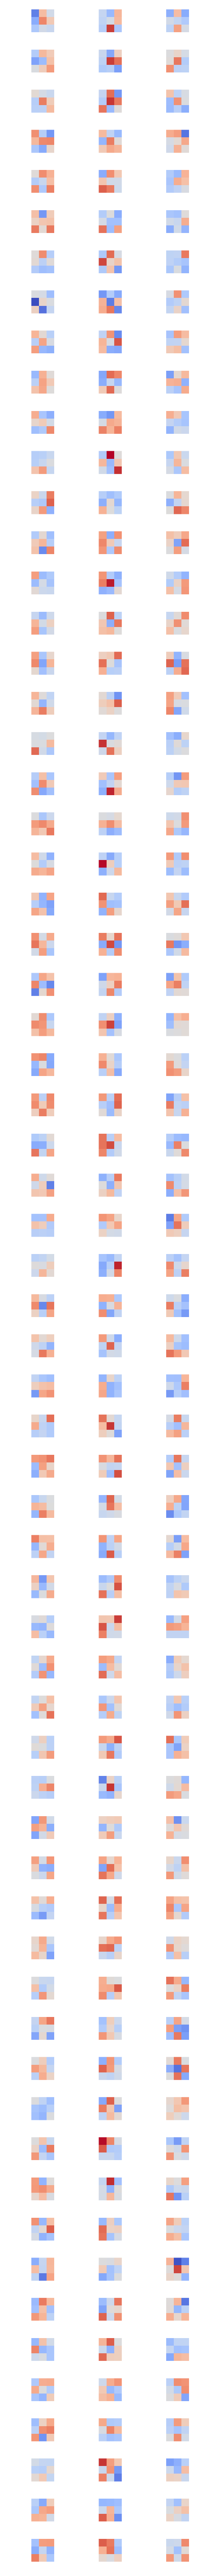

In [21]:
draw_filters(model.get_weights()[0], figsize=(6,72))